In [1]:
from processed_data import GreyUTKFace
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [2]:
%%time
train_dataset = GreyUTKFace.Dataset(train=True)
test_dataset = GreyUTKFace.Dataset(train=False)

CPU times: user 2min 17s, sys: 9.01 s, total: 2min 26s
Wall time: 24.6 s


torch.Size([1, 200, 200])


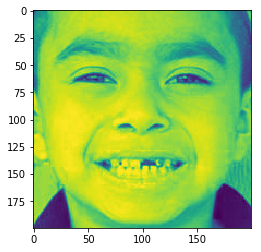

In [3]:
sample_item = train_dataset[0][0]
print(sample_item.shape)
# Should be C x W x H (1, 200, 200)
plt.imshow(sample_item[0])

In [4]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import copy
import numpy as np
from models.GreyUTKFace.VAE import Model
import os

model_dir = 'models/GreyUTKFace/VAE/'

parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--load', action='store_true', default=False, help='Skip Training')
args = parser.parse_args([])
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if args.cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=args.batch_size, shuffle=True, **kwargs)

model = Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 1, 200, 200), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    avg_loss = train_loss / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, avg_loss))
    return avg_loss


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 200, 200)[:n]])
                save_image(comparison.cpu(),
                         model_dir + 'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

def main():
    print(device)
    test_losses = []
    train_losses = []
    weight_path = model_dir + 'weights/model.pt'
    if os.path.exists(weight_path):
        model.load_state_dict(torch.load(weight_path))
        print('Loaded a saved model')
    else:
        print('Starting model from scratch')
    for epoch in range(1, args.epochs + 1):
        train_loss = train(epoch)
        test_loss = test(epoch)
        
        test_losses.append(test_loss)
        train_losses.append(train_loss)
        
        with torch.no_grad():
            sample = torch.randn(64, 32).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 200, 200),
                       model_dir + 'results/sample_' + str(epoch) + '.png')
            
    torch.save(model.state_dict(), weight_path)
    
    plt.plot(np.arange(len(train_losses)), train_losses)
    plt.plot(np.arange(len(test_losses)), test_losses)


ERROR:root:No traceback has been produced, nothing to debug.


cuda
Starting model from scratch
Train Epoch: 1 [0/18966 (0%)]	Loss: 27492.074219
Train Epoch: 1 [1280/18966 (7%)]	Loss: 27087.869141
Train Epoch: 1 [2560/18966 (13%)]	Loss: 26340.191406
Train Epoch: 1 [3840/18966 (20%)]	Loss: 26410.109375
Train Epoch: 1 [5120/18966 (27%)]	Loss: 26242.162109
Train Epoch: 1 [6400/18966 (34%)]	Loss: 25722.056641
Train Epoch: 1 [7680/18966 (40%)]	Loss: 25526.546875
Train Epoch: 1 [8960/18966 (47%)]	Loss: 27668.783203
Train Epoch: 1 [10240/18966 (54%)]	Loss: 26531.902344
Train Epoch: 1 [11520/18966 (60%)]	Loss: 25796.970703
Train Epoch: 1 [12800/18966 (67%)]	Loss: 25823.853516
Train Epoch: 1 [14080/18966 (74%)]	Loss: 25521.001953
Train Epoch: 1 [15360/18966 (81%)]	Loss: 25663.652344
Train Epoch: 1 [16640/18966 (87%)]	Loss: 25227.833984
Train Epoch: 1 [17920/18966 (94%)]	Loss: 24645.642578
====> Epoch: 1 Average loss: 26011.8872
====> Test set loss: 24626.4440
Train Epoch: 2 [0/18966 (0%)]	Loss: 24496.623047
Train Epoch: 2 [1280/18966 (7%)]	Loss: 24917.1855

Train Epoch: 10 [8960/18966 (47%)]	Loss: 22056.367188
Train Epoch: 10 [10240/18966 (54%)]	Loss: 22035.130859
Train Epoch: 10 [11520/18966 (60%)]	Loss: 21956.058594
Train Epoch: 10 [12800/18966 (67%)]	Loss: 21736.773438
Train Epoch: 10 [14080/18966 (74%)]	Loss: 21984.871094
Train Epoch: 10 [15360/18966 (81%)]	Loss: 21767.724609
Train Epoch: 10 [16640/18966 (87%)]	Loss: 21640.462891
Train Epoch: 10 [17920/18966 (94%)]	Loss: 21204.378906
====> Epoch: 10 Average loss: 21812.6326
====> Test set loss: 21821.2588
CPU times: user 3min 50s, sys: 1min 47s, total: 5min 37s
Wall time: 4min 52s


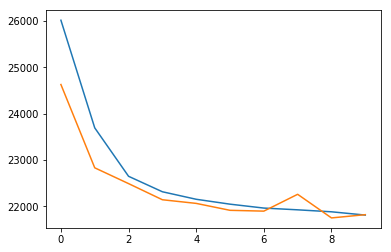

In [5]:
%%time
%debug
main()